# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, precision_recall_curve

# Configs

In [2]:
LABELED_PATH = "../data/results/labels.parquet"
PREDICTED_PATH = "../data/results/xgb_prediction_labeled.parquet"
TEST_START_DATE = '2023-04-01'

In [68]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

## Load labeled data

In [3]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [4]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df

,Location,Date,Demand
0,1,2023-04-01,13.0
1,1,2023-04-02,17.0
2,1,2023-04-03,9.0
3,1,2023-04-04,12.0
4,1,2023-04-05,18.0
...,...,...,...
7855,265,2023-04-26,78.0
7856,265,2023-04-27,44.0
7857,265,2023-04-28,55.0
7858,265,2023-04-29,45.0


In [5]:
predicted_df = pd.read_parquet(PREDICTED_PATH)
predicted_df.tail()

,Location,Date,Predicted_demand
7855,265,2023-04-26,53.553493
7856,265,2023-04-27,76.140839
7857,265,2023-04-28,56.882065
7858,265,2023-04-29,55.795795
7859,265,2023-04-30,55.706608


In [6]:
actual_predicted_df = test_df.copy()
actual_predicted_df['Predicted_demand'] = predicted_df['Predicted_demand']
actual_predicted_df.isna().sum()

Location            0
Date                0
Demand              0
Predicted_demand    0
dtype: int64

In [7]:
actual_predicted_df.head()

,Location,Date,Demand,Predicted_demand
0,1,2023-04-01,13.0,9.159037
1,1,2023-04-02,17.0,5.113592
2,1,2023-04-03,9.0,11.624486
3,1,2023-04-04,12.0,9.921972
4,1,2023-04-05,18.0,7.794608


## Data General information

### Demands Histogram

In [120]:
def plot_histogram(plot_df, bin, title):
    plt.figure(figsize=(6,4))
    n, bins, patches = plt.hist(plot_df, 
                                bins=bin,
                                edgecolor = 'black')
    plt.title(title)
    plt.show()

    demand_histogram_table = pd.DataFrame({
        'bin_limit': tuple(np.round(np.stack((bins[:-1], bins[1:]), axis=1), decimals = 2)),
        'counts': n
    })

    return demand_histogram_table

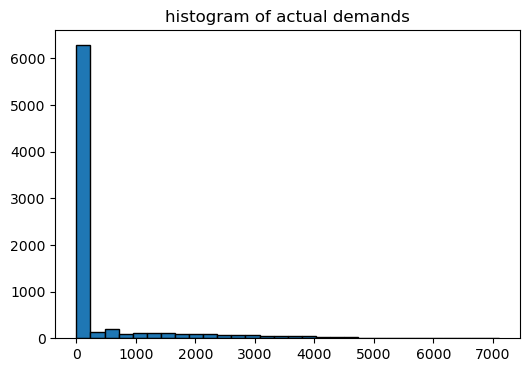

In [121]:
demand_histogram_df = plot_histogram(test_df.Demand, 
                                     bin=30, 
                                     title='histogram of actual demands')

In [10]:
print("Histogram of actual Demand:\n")
demand_histogram_df.head()

Histogram of actual Demand:



,bin_limit,counts
0,"[0.0, 236.73]",6289.0
1,"[236.73, 473.47]",143.0
2,"[473.47, 710.2]",195.0
3,"[710.2, 946.93]",96.0
4,"[946.93, 1183.67]",114.0


### Check 'zero' demands in locations

In [11]:
def zero_demand_location(labeled_df):

    ind_low_demand_loc = labeled_df.groupby('Location')['Demand'].min()==0
    low_demand_location = ind_low_demand_loc[ind_low_demand_loc==True].index
    number_low_demand_location = len(low_demand_location)+3
    percentage_low_demand_location = number_low_demand_location*100/265

    print(f'number of locations that have at least one zero demand: {number_low_demand_location}')
    print(f'percentage of locations that have at least one zero demand: {percentage_low_demand_location}')

    low_demand = {}
    zero_demand_loc = [i for i in range(1,266) if i not in labeled_df.Location.values]
    low_demand['zero_demand_location'] = list(low_demand_location) + zero_demand_loc
    low_demand['total_demand'] = [labeled_df.Demand[labeled_df.Location==i].sum() for i in low_demand_location] + [0,0,0]
    low_demand = pd.DataFrame(low_demand).sort_values(by='total_demand', ascending=False).reset_index(drop=True)

    return low_demand

In [12]:
low_demand = zero_demand_location(labeled_df)
low_demand.head()

number of locations that have at least one zero demand: 140
percentage of locations that have at least one zero demand: 52.83018867924528


,zero_demand_location,total_demand
0,51,1086.0
1,207,975.0
2,36,953.0
3,191,852.0
4,218,823.0


### Finding Important Locations

In [122]:
def plot_cumsum_demand(labeled_df, target_demand):
    grouped_df = labeled_df.groupby('Location')['Demand'].sum().reset_index().sort_values(by='Demand', ascending=False).reset_index()
    cumulative_demand = (grouped_df['Demand'].cumsum() / grouped_df['Demand'].sum()).to_numpy()

    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(labeled_df['Location'].unique())+1), cumulative_demand)
    plt.xlabel('Location numbers')
    plt.ylabel('Cumulative Demand')
    plt.title('Cumulative Demand by Location')
    target_x = (cumulative_demand <= target_demand).argmin()
    plt.axhline(y=target_demand, color='r', linestyle='--', label=f'Target Demand ({target_demand})')
    plt.axvline(x=target_x, color='g', linestyle='--', label=f'Target Location ({target_x})')

    plt.legend() 
    plt.show()
    important_locations = grouped_df.iloc[:target_x, grouped_df.columns.get_loc('Location')]
    important_locations = important_locations.to_numpy()
    return important_locations

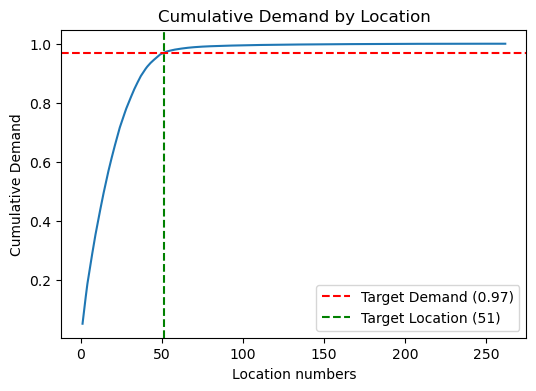

In [123]:
important_locations = plot_cumsum_demand(labeled_df, 0.97)

In [91]:
important_locations

array([132, 237, 161, 236, 162, 186, 230, 142, 138, 170, 163, 239,  48,
       234,  68, 141,  79, 164, 249, 107, 140, 263, 238, 229, 100,  90,
        43, 246, 262, 113, 231, 114, 233, 137, 143, 264, 148, 158, 144,
       151, 211,  50,  75,  13, 125,  87, 166, 261,  70,  24,  88])

# Evaluation

## High Demand Locations Report

In [15]:
high_demand_locations_df = actual_predicted_df\
                                    .loc[actual_predicted_df['Location'].isin(important_locations)]\
                                        .reset_index(drop=True)
high_demand_locations_df

,Location,Date,Demand,Predicted_demand
0,13,2023-04-01,518.0,605.541565
1,13,2023-04-02,395.0,428.947205
2,13,2023-04-03,625.0,482.903015
3,13,2023-04-04,737.0,694.965149
4,13,2023-04-05,666.0,816.690491
...,...,...,...,...
1525,264,2023-04-26,1110.0,1050.984497
1526,264,2023-04-27,1230.0,1318.975952
1527,264,2023-04-28,1310.0,1237.217651
1528,264,2023-04-29,1367.0,1387.318604


### plot histogram of errors (measure over/under steamated)

In [16]:
def plot_hist(rides_df, bin):
    
    
    plt.rcParams['figure.figsize'] = (40, 70)

    for i,loc in enumerate(rides_df.Location.unique()):
        
        plt.subplot(17,3,i+1)

        error = rides_df[rides_df.Location==loc]['Demand'] - rides_df[rides_df.Location==loc]['Predicted_demand']
        under_estimate_percentage = error[error>0].count()*100/len(error)
        over_estimate_percentage = error[error<0].count()*100/len(error) 
        
        sb.histplot(error, kde=True, bins=bin, label=f'Histogram and Estimated density of Error for Location{loc}', color='green')

        mu=0
        sigma=np.std(error)    
        x = np.linspace(np.min(error), np.max(error), 100)
        y = norm.pdf(x, mu, sigma)
        kde_max = np.max(sb.histplot(error, kde=True, bins=bin).get_lines()[0].get_data()[1])
        y *= kde_max / np.max(y)
        
        plt.plot(x, y, 'r-', label='Normal Gaussian Distribution')
        plt.ylabel('Count', fontsize=25)
        plt.xlabel('Error', fontsize=20)
        plt.tick_params(axis='both', labelsize=13)
        plt.legend(fontsize='17')
        plt.title(f'percentage of underestimate: {under_estimate_percentage:.1f}\npercentage of overestimate: {over_estimate_percentage:.1f}', fontsize=25)
    plt.tight_layout()
    plt.show()

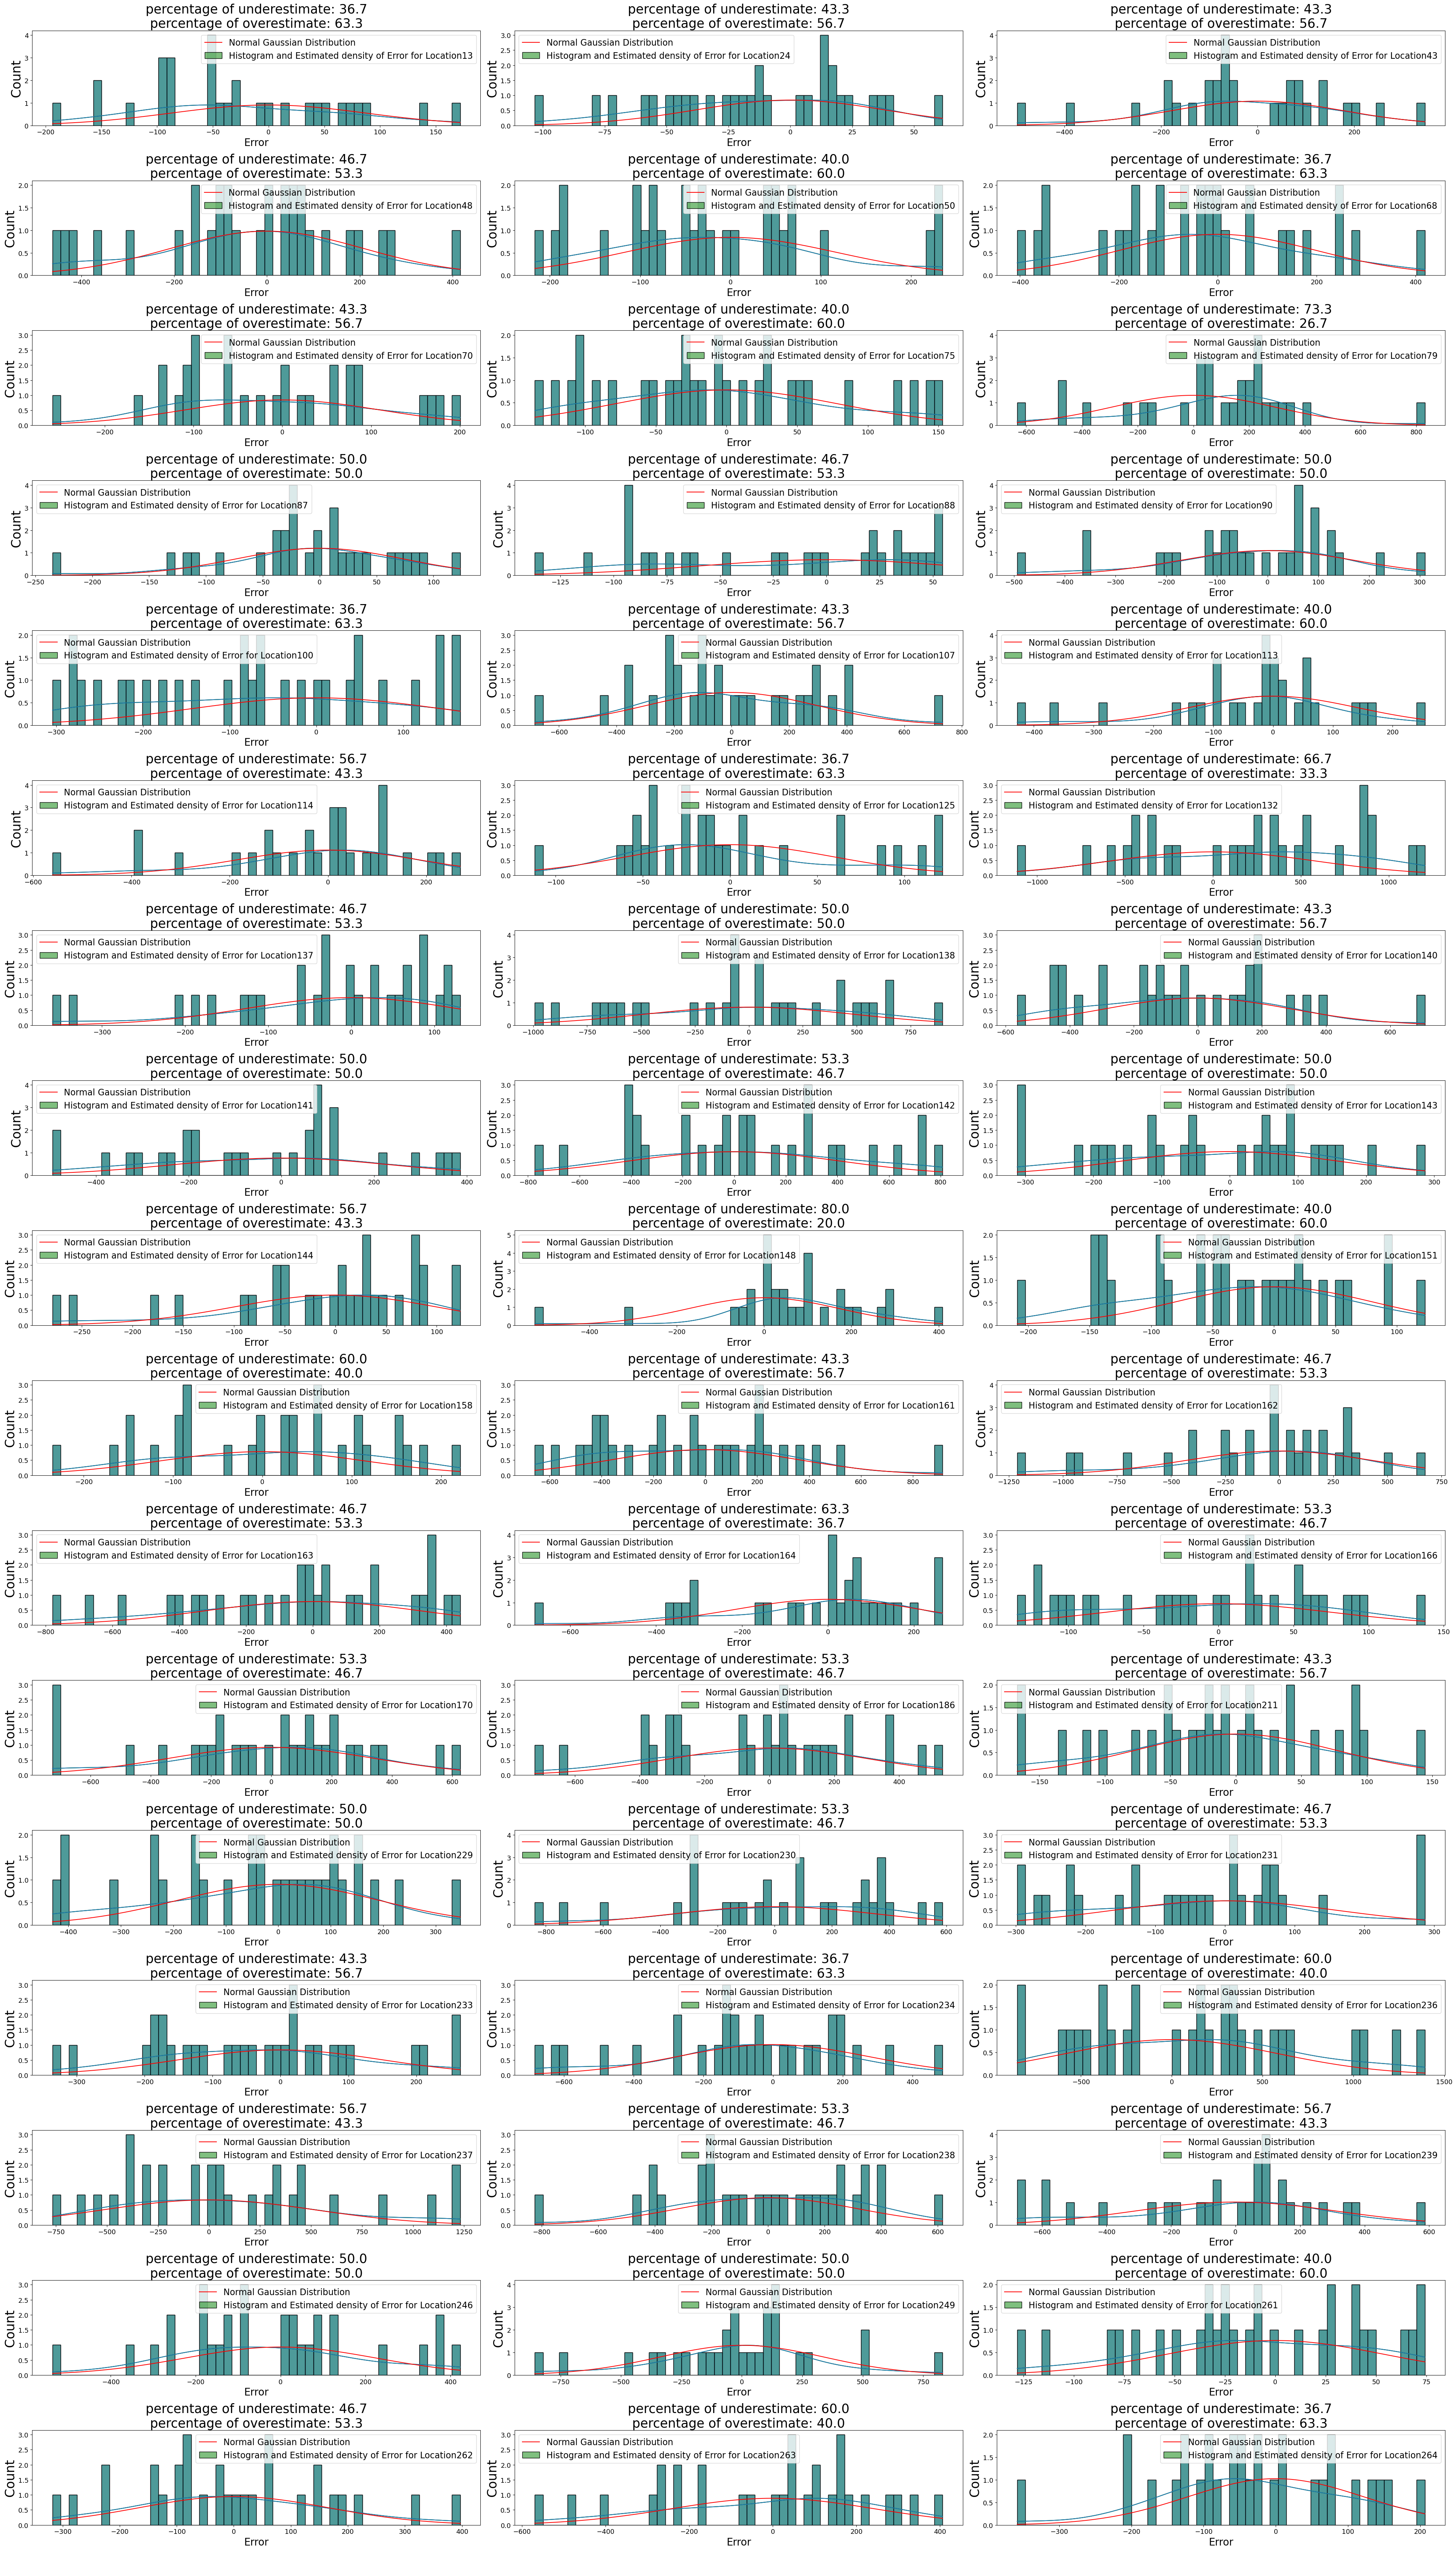

In [96]:
plot_hist(high_demand_locations_df, bin = 50)

### calculate mape

In [17]:
def calculate_mape(actual_predicted_df:pd.DataFrame):
    
    actual_predicted_df['error'] = (
        np.abs(actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand'])
        /actual_predicted_df['Demand']
        )*100

    error_per_location = (actual_predicted_df
                                .groupby('Location')
                                .mean())[['Demand', 'Predicted_demand', 'error']]
    error_per_date = (actual_predicted_df
                                .groupby('Date')
                                .mean())[['Demand', 'Predicted_demand', 'error']]
                     
    actual_predicted_df['day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
    error_per_dayofweek = (actual_predicted_df
                                .groupby('day_of_week')
                                .mean())[['Demand', 'Predicted_demand', 'error']]

    return error_per_location, error_per_date, error_per_dayofweek


### plot mape

In [18]:

def plot_mape(errors: pd.DataFrame, per):
    errors = errors
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
    errors.plot(y='error', ax=axes, color='red', kind='line', marker='o')
    
    thresholds = pd.DataFrame({'min':[errors['error'].min()], 
                               'mean':[errors['error'].mean()], 
                               'max':[errors['error'].max()]})
    for i, thre in enumerate(thresholds):
            threshold = pd.DataFrame(index=errors.index)
            threshold[str(thresholds.columns[i])] = [thresholds[thre][0]]*len(errors)
            threshold.plot(ax=axes, kind='line', label=str(thre), linestyle='--')
        
    plt.xlabel(str(per))
    title = 'Model MAPE per ' + str(per) 
    plt.title(title)

    plt.show()

In [69]:
error_per_location, error_per_date, error_per_dayofweek = calculate_mape(high_demand_locations_df)

In [20]:
print(error_per_location.shape)
error_per_location.head()

(51, 3)


,Demand,Predicted_demand,error
Location,,,
13,602.866667,627.768005,13.480576
24,296.733333,309.678223,11.343392
43,1861.366667,1888.126587,8.419724
48,2983.800000,3023.892090,5.795821
50,732.600000,750.078918,12.856721


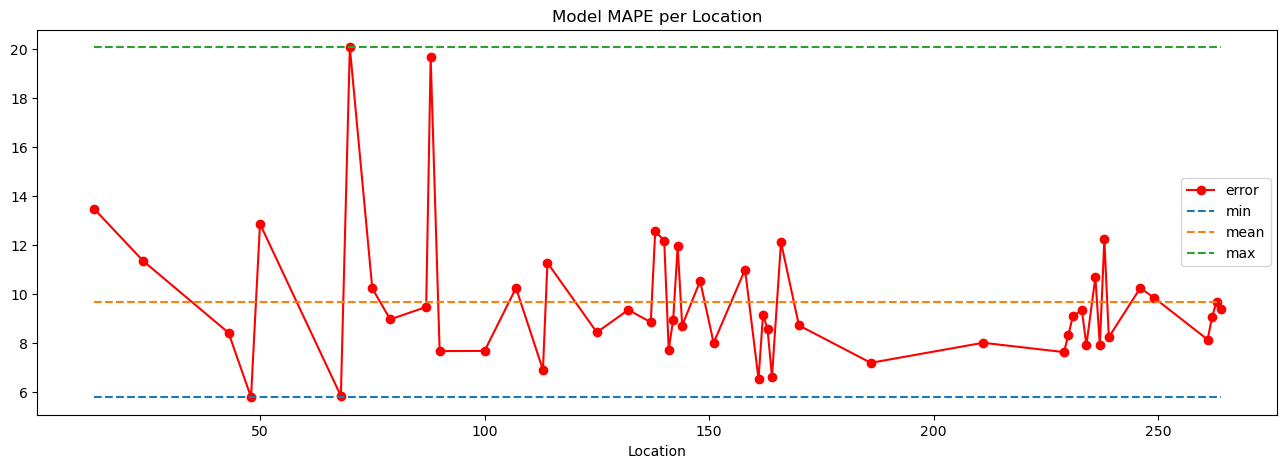

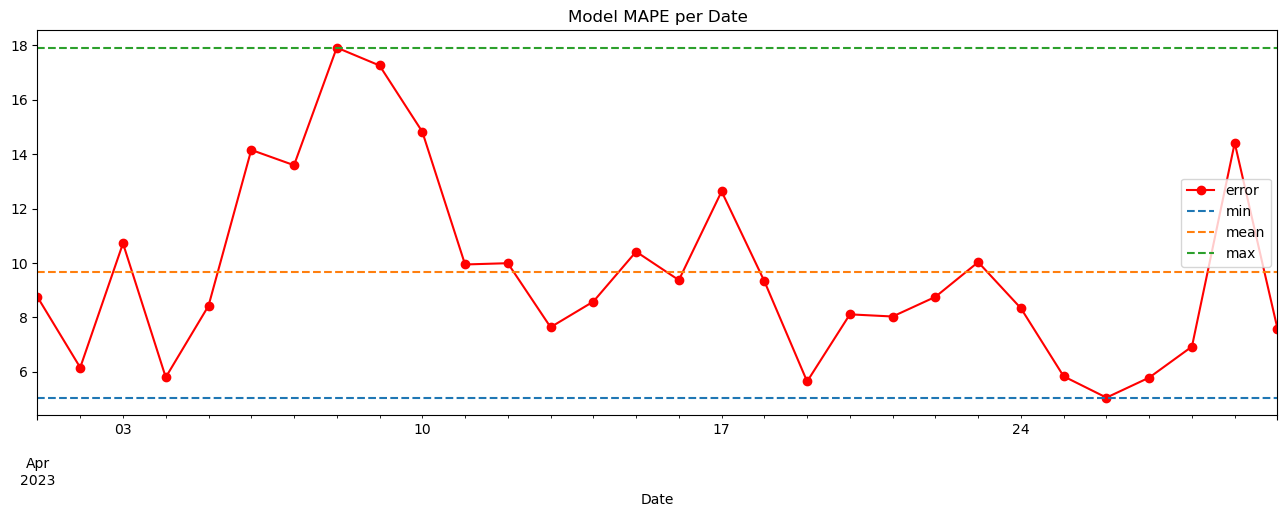

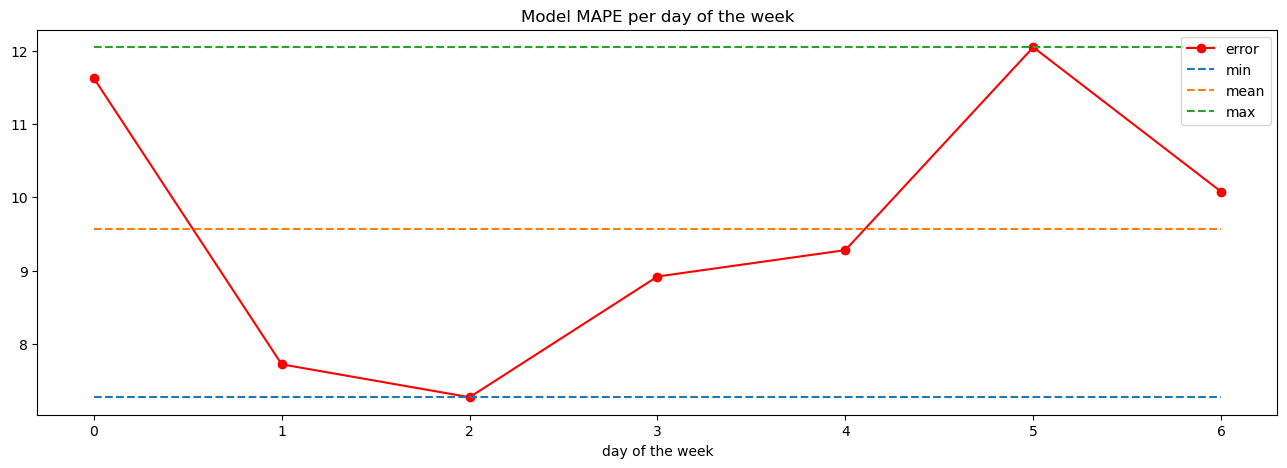

In [21]:
plot_mape(error_per_location, 'Location')
plot_mape(error_per_date, 'Date')
plot_mape(error_per_dayofweek, 'day of the week')

### PLot Histogram of MAPE

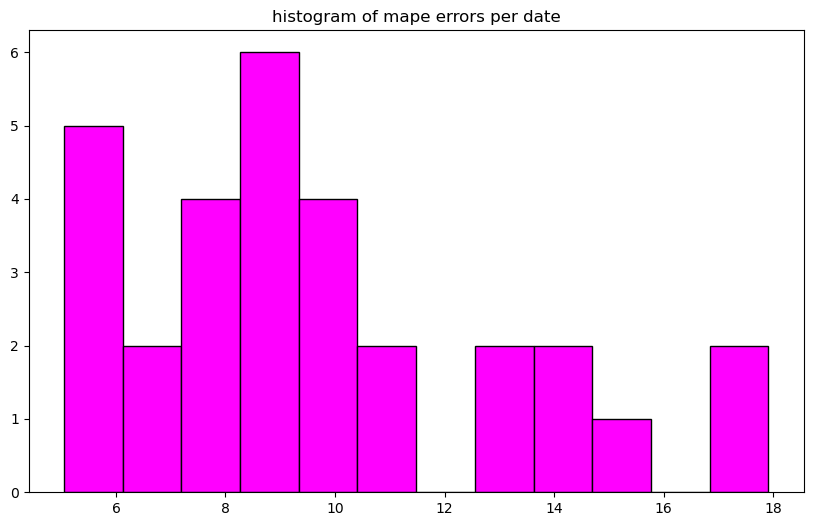

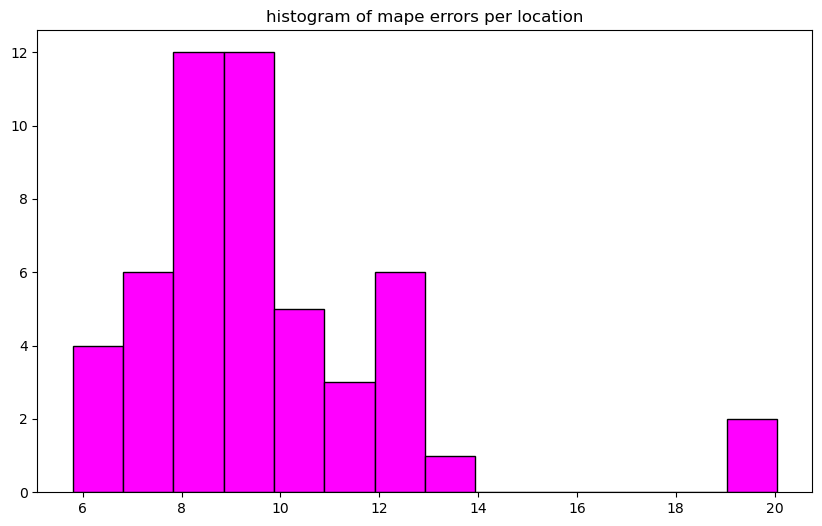

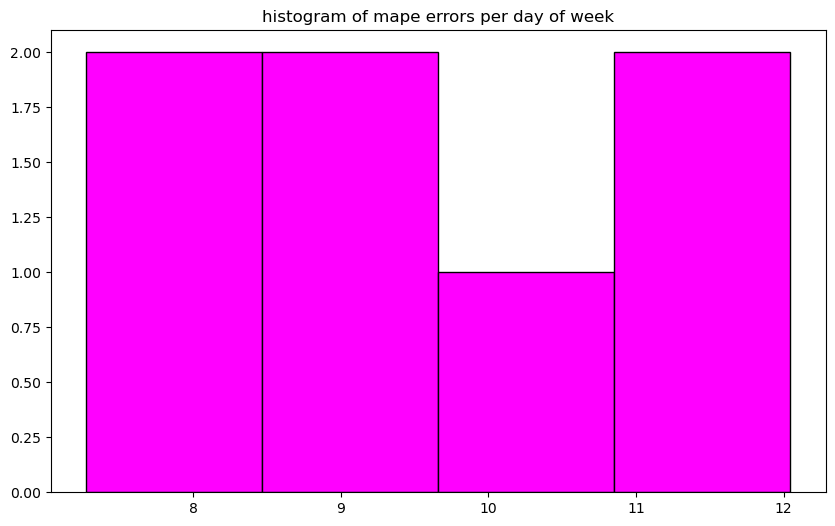

In [29]:
d_bin = int((error_per_date.error.max()-error_per_date.error.min()))
date_error_histogram_df = plot_histogram(error_per_date.error, d_bin, 'histogram of mape errors per date')

l_bin = int((error_per_location.error.max()-error_per_location.error.min()))
location_error_histogram_df = plot_histogram(error_per_location.error, l_bin, 'histogram of mape errors per location')

dow_bin = int((error_per_dayofweek.error.max()-error_per_dayofweek.error.min()))
dayofweek_error_histogram_df = plot_histogram(error_per_dayofweek.error, dow_bin, 'histogram of mape errors per day of week')

### Boundry Report

#### Generate Baseline Predict

In [94]:
def baseline_predict(dataset, shift_val):
    predicted_demand = dataset.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Predicted_demand'] = predicted_demand
    return predicted_data

In [95]:
actual_high_damand = test_df.loc[test_df['Location'].isin(important_locations)]\
                                        .reset_index(drop=True)
actual_high_damand

,Location,Date,Demand
0,13,2023-04-01,518.0
1,13,2023-04-02,395.0
2,13,2023-04-03,625.0
3,13,2023-04-04,737.0
4,13,2023-04-05,666.0
...,...,...,...
1525,264,2023-04-26,1110.0
1526,264,2023-04-27,1230.0
1527,264,2023-04-28,1310.0
1528,264,2023-04-29,1367.0


In [102]:
baseline_1d_predicted_high_damand = baseline_predict(actual_high_damand, 1)
baseline_1d_predicted_high_damand=baseline_1d_predicted_high_damand.dropna()
baseline_1d_predicted_high_damand.head()

,Location,Date,Predicted_demand
1,13,2023-04-02,518.0
2,13,2023-04-03,395.0
3,13,2023-04-04,625.0
4,13,2023-04-05,737.0
5,13,2023-04-06,666.0


In [105]:
baseline_7d_predicted_high_damand = baseline_predict(actual_high_damand, 7)
baseline_7d_predicted_high_damand = baseline_7d_predicted_high_damand.dropna()
baseline_7d_predicted_high_damand.head()

,Location,Date,Predicted_demand
7,13,2023-04-08,518.0
8,13,2023-04-09,395.0
9,13,2023-04-10,625.0
10,13,2023-04-11,737.0
11,13,2023-04-12,666.0


In [111]:
actual_baseline_1d_predicted_df = actual_high_damand.copy()
actual_baseline_1d_predicted_df['Predicted_demand'] = baseline_1d_predicted_high_damand['Predicted_demand']
actual_baseline_1d_predicted_df =actual_baseline_1d_predicted_df.dropna()
actual_baseline_1d_predicted_df.head()

,Location,Date,Demand,Predicted_demand
1,13,2023-04-02,395.0,518.0
2,13,2023-04-03,625.0,395.0
3,13,2023-04-04,737.0,625.0
4,13,2023-04-05,666.0,737.0
5,13,2023-04-06,703.0,666.0


In [113]:
actual_baseline_7d_predicted_df = actual_high_damand.copy()
actual_baseline_7d_predicted_df['Predicted_demand'] = baseline_7d_predicted_high_damand['Predicted_demand']
actual_baseline_7d_predicted_df = actual_baseline_7d_predicted_df.dropna()
actual_baseline_7d_predicted_df.head()

,Location,Date,Demand,Predicted_demand
7,13,2023-04-08,485.0,518.0
8,13,2023-04-09,367.0,395.0
9,13,2023-04-10,490.0,625.0
10,13,2023-04-11,638.0,737.0
11,13,2023-04-12,756.0,666.0


#### Error for Baseline(predict demand = previouse day)

In [114]:
baseline_error_per_location, baseline_error_per_date, baseline_error_per_dayofweek = calculate_mape(actual_baseline_1d_predicted_df)

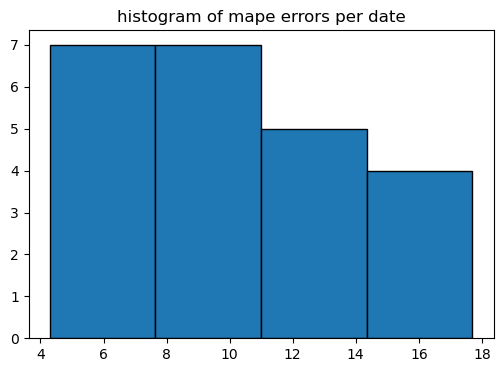

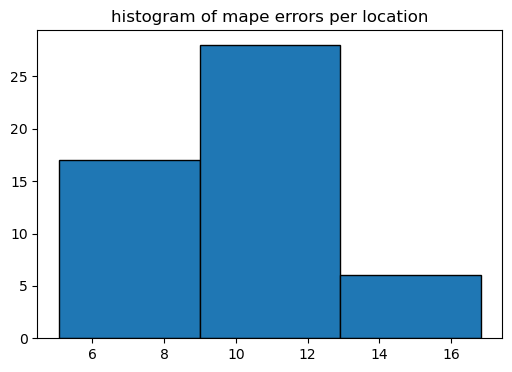

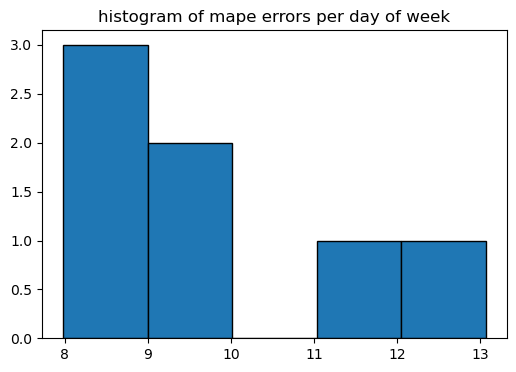

In [126]:
d_bin = int((baseline_error_per_date.error.max()-baseline_error_per_date.error.min())/3)
date_error_histogram_df = plot_histogram(baseline_error_per_date.error, d_bin, 'histogram of mape errors per date')

l_bin = int((baseline_error_per_location.error.max()-baseline_error_per_location.error.min())/3)
location_error_histogram_df = plot_histogram(baseline_error_per_location.error, l_bin, 'histogram of mape errors per location')

dow_bin = int((baseline_error_per_dayofweek.error.max()-baseline_error_per_dayofweek.error.min()))
dayofweek_error_histogram_df = plot_histogram(baseline_error_per_dayofweek.error, dow_bin, 'histogram of mape errors per day of week')

#### Error for Baseline(predict demand = previouse week)

In [117]:
baseline_error_per_location, baseline_error_per_date, baseline_error_per_dayofweek = calculate_mape(actual_baseline_7d_predicted_df)

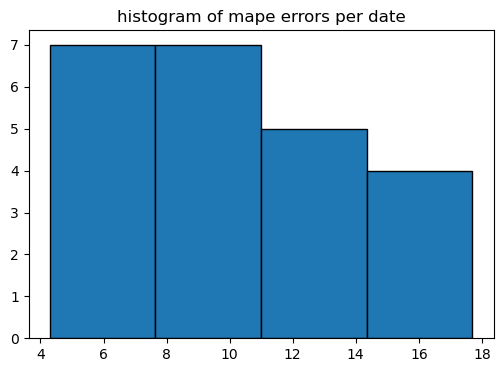

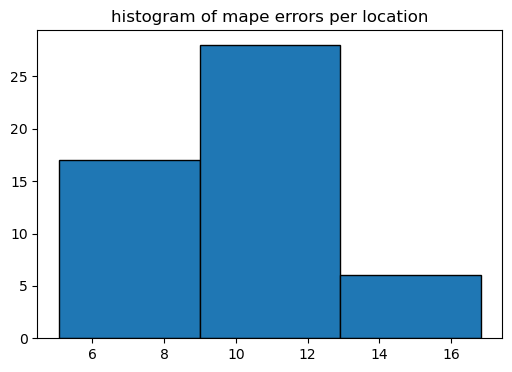

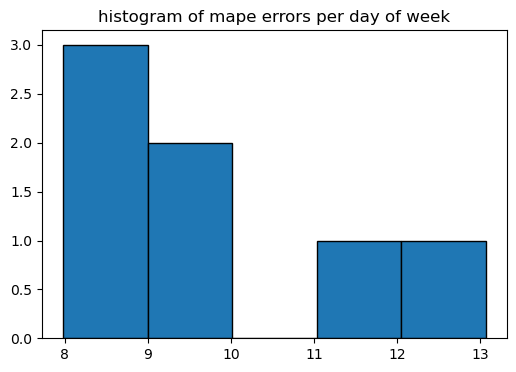

In [125]:
d_bin = int((baseline_error_per_date.error.max()-baseline_error_per_date.error.min())/3)
date_error_histogram_df = plot_histogram(baseline_error_per_date.error, d_bin, 'histogram of mape errors per date')

l_bin = int((baseline_error_per_location.error.max()-baseline_error_per_location.error.min())/3)
location_error_histogram_df = plot_histogram(baseline_error_per_location.error, l_bin, 'histogram of mape errors per location')

dow_bin = int((baseline_error_per_dayofweek.error.max()-baseline_error_per_dayofweek.error.min()))
dayofweek_error_histogram_df = plot_histogram(baseline_error_per_dayofweek.error, dow_bin, 'histogram of mape errors per day of week')

## Low Demand Locations Report

In [ ]:
low_demand_locations_df = actual_predicted_df\
                                    .loc[~actual_predicted_df['Location'].isin(important_locations)]\
                                        .reset_index(drop = True)
low_demand_locations_df

,Location,Date,Demand,Predicted_demand
0,1,2023-04-01,13.0,9.159037
1,1,2023-04-02,17.0,5.113592
2,1,2023-04-03,9.0,11.624486
3,1,2023-04-04,12.0,9.921972
4,1,2023-04-05,18.0,7.794608
...,...,...,...,...
6325,265,2023-04-26,78.0,53.553493
6326,265,2023-04-27,44.0,76.140839
6327,265,2023-04-28,55.0,56.882065
6328,265,2023-04-29,45.0,55.795795


### Calculate Accuracy

In [ ]:
def accuracy_per_location(actual_predicted_df: pd.DataFrame):
    num_loc = actual_predicted_df['Location'].unique()
    per_rec_location = pd.DataFrame(columns=['Location','Date', 'Demand', 'Predicted_demand', 'actual_class','predict_class'])
    for loc in num_loc:
        loc_df = actual_predicted_df.loc[actual_predicted_df['Location']==loc]
        loc_mean_demand = loc_df['Demand'].mean()
        loc_df['actual_class'] = loc_df['Demand']-loc_mean_demand
        loc_df['predict_class'] = loc_df['Predicted_demand']-loc_mean_demand
        per_rec_location = pd.concat([per_rec_location,loc_df])
            
    y_test = np.where(per_rec_location['actual_class']>0,1,0)
    y_pred = np.where(per_rec_location['predict_class']>0,1,0)
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Print the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    title = 'Confusion Matrix for low demand locations:'
    plt.title(title, fontsize=18)
    plt.show()
    print(f'Accuracy score: {accuracy}\nPrecision score: {precision}\nRecall score: {recall}')
    return per_rec_location, y_test, y_pred

    

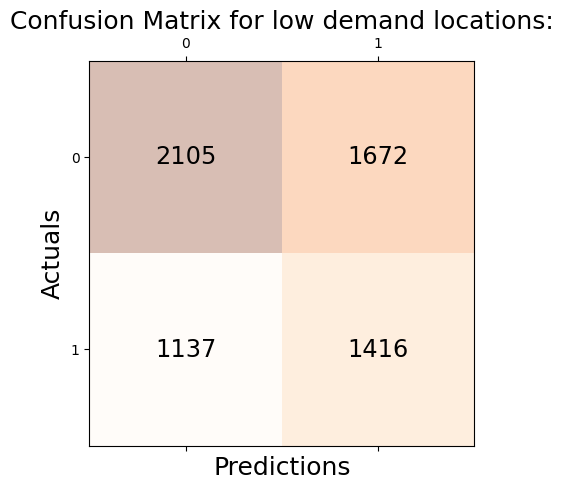

Accuracy score: 0.5562401263823065
Precision score: 0.4585492227979275
Recall score: 0.554641598119859


In [137]:
accuracy_per_location_df, test_labels, pred_labels = accuracy_per_location(low_demand_locations_df)

In [ ]:
accuracy_per_location_df.head()

,Location,Date,Demand,Predicted_demand,actual_class,predict_class
0,1,2023-04-01,13.0,9.159037,-2.066667,-5.907630
1,1,2023-04-02,17.0,5.113592,1.933333,-9.953075
2,1,2023-04-03,9.0,11.624486,-6.066667,-3.442181
3,1,2023-04-04,12.0,9.921972,-3.066667,-5.144694
4,1,2023-04-05,18.0,7.794608,2.933333,-7.272059


### Roc Curve

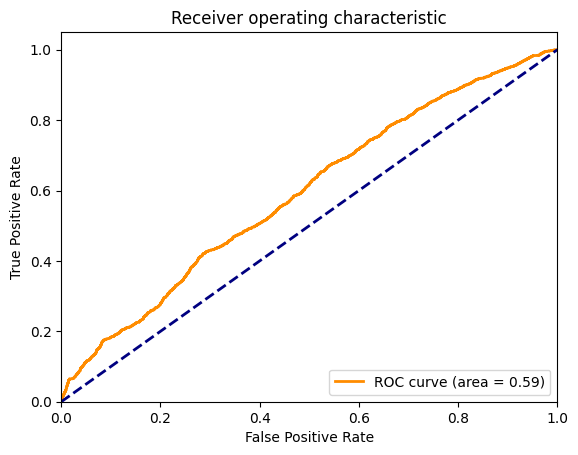

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, accuracy_per_location_df['predict_class'].to_numpy())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


### Precision Recall Curve

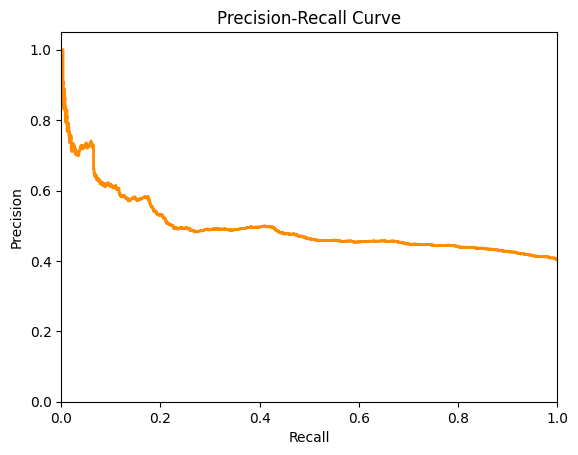

In [ ]:
precision, recall, thresholds = precision_recall_curve(test_labels, accuracy_per_location_df['predict_class'].to_numpy())

plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()
